In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# generate more tomatoe-like data

# BIG DATA
N = 10000
d1 = np.random.normal(11.2115,0.5486,int(N/3))
d2 = np.random.normal(13.5618,0.62927,int((N-int(N/3))/2))
d3 = np.random.normal(16.115,0.5714,N-2*int((N-int(N/3))/2))

BigY = np.random.choice(np.concatenate([d1,d2,d3]), N, replace=True)

In [36]:
Y=np.load('tomatoes.npy') 
print('Length of data: ' + str(len(Y)))
print('Data:')
print(Y)

Length of data: 30
Data:
[13.27597167 15.08565281 13.41061844 11.5510474  10.63232069 13.76932811
 10.31644803 14.55388057 12.57937117 14.13647951 15.37354413  9.96525246
 12.66541964 11.33164599 12.14113179 11.57753389 15.86128067 10.23999543
 16.36971379 13.96021609 17.27321719 12.23476479 17.96792692 13.92888826
 10.64602864 16.45922776 15.56009798 13.02118014 16.50556431 14.08484862]


In [117]:
def likelihood_grad(y_batch,q):
    m1,m2,m3 = q 
    batch_length = len(y_batch)
    m1_vec = m1*np.ones(batch_length)
    m2_vec = m2*np.ones(batch_length)
    m3_vec = m3*np.ones(batch_length)
    p_hat = np.exp(-(y_batch-m1_vec)**2/2) + np.exp(-(y_batch-m2_vec)**2/2) + np.exp(-(y_batch-m3_vec)**2/2)
#     if (np.mean(p_hat < .01)):
#         print(p_hat)
#         print('masses:', m1,m2,m3)
        
    grad1 = -(y_batch - m1_vec)*np.exp(-(y_batch - m1_vec)**2/2)/p_hat
    grad2 = -(y_batch - m2_vec)*np.exp(-(y_batch - m2_vec)**2/2)/p_hat
    grad3 = -(y_batch - m3_vec)*np.exp(-(y_batch - m3_vec)**2/2)/p_hat
        
    grad = np.array([grad1,grad2,grad3])
        
    return grad


def force_noise_with_cov(q,y_batch,batch_scaling):
    n = len(y_batch)
    m1,m2,m3 = q  
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    
    grad_prior = np.array([[-(1/16)*(13.5 - m1)], [-(1/16)*(13.5 - m2)], [-(1/16)*(13.5 - m3)]])
    
    
    # Take the negative of each gradient
    grad_m1 = -(grad_prior[0] + batch_scaling*sum(likelihood_grad(y_batch,q)[0]))  
    grad_m2 = -(grad_prior[1] + batch_scaling*sum(likelihood_grad(y_batch,q)[1]))
    grad_m3 = -(grad_prior[2] + batch_scaling*sum(likelihood_grad(y_batch,q)[2]))
    
    s_ti = np.zeros([3,n])
    for i in range(n):
        s = (1/n)*grad_prior + likelihood_grad([y_batch[i]],q)
        s_ti[:,i] = s[:,0]
        
    cov_est = batch_scaling**2 * np.cov(s_ti)   # covariance of the scores s_ti to estimate covariance matrix
    
    grad = np.array([grad_m1, grad_m2, grad_m3])
    
    return grad, cov_est

In [20]:
def get_minibatch_with_cov(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n]
    y = y[n:]
    return batch, y

In [108]:
def mSGLD(q,h,y,batch_scaling,batch_size):# n is batch size
    
    
    R = np.random.normal(0,1,len(q))
    
    (y_batch, y_updated) = get_minibatch_with_cov(y,batch_size)
    grad, cov_est = force_noise_with_cov(q,y_batch,batch_scaling)
    
    
    
    #cov_U=np.mean((0.5*stochastic_force(q,y,N)-np.mean(0.5*stochastic_force(q,y,N)))*(0.5*stochastic_force(q,y,N)-np.mean(0.5*stochastic_force(q,y,N))))

    # np.dot(np.sqrt(h-h**2*cov_est/4),R) 
    q = q + (h/2) * np.matrix.flatten(grad) + np.dot(np.sqrt(h)*(1-(h/2)*cov_est), R)  #(np.identity(3)-0.5*h*cov_U)*R
    
    return q,y_updated
    

In [48]:
def run_simulation_mSGLD( q0, Nsteps, h, step_function, Y, batch_size):
    num_scans = len(Y)/batch_size - 1
    q_traj = [np.copy(q0)] 
    t_traj = [0]

    q = np.copy(q0) 
    t = 0 
    y_updated = Y
    batch_scaling = len(Y)/batch_size
    scans = num_scans
    for n in range(Nsteps):
        if scans == 0:
            scans = num_scans
            y_updated = Y
        q,y_updated = step_function(q, h, y_updated, batch_scaling, batch_size)
        t = t + h 

        q_traj += [q] 
        t_traj += [t]
        scans = scans - 1

    q_traj = np.array(q_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, t_traj

In [121]:
#using mSGLD
q0 = np.random.randn(3) + 13   # initialise q0 to be close to the mean (of tomato mass)
#q0 = 12*np.ones(3)

Nsteps = 100000
h = 0.1

# Run one long trajectory of Nsteps, using the OBABO scheme
q_traj, t_traj = run_simulation_mSGLD(q0, Nsteps , h, mSGLD, Y, 10)



In [124]:
print(q_traj)

[[12.91386342 10.17142509 13.07408159]
 [13.98262188 10.43648578 14.59765013]
 [13.94705432 10.60451661 15.24158084]
 ...
 [12.61902895 10.48505217 15.43106828]
 [12.84153981 10.76711248 15.89191747]
 [13.30641748 10.75508021 15.52068281]]


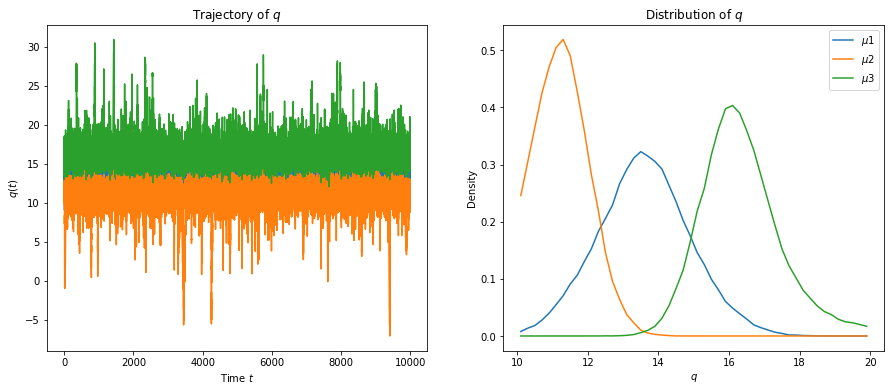

In [122]:
# mSGLD
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

histogram_m1,bins_m1 = np.histogram(q_traj[:,0],bins=50,range=[10,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.subplot(1,2,2)

plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(q_traj[:,1],bins=50,range=[10,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(q_traj[:,2],bins=50,range=[10,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

Mean 1: 10.688825060786439 Standard Deviation: 1.8805870989377014
Mean 2: 13.586611901303808 Standard Deviation: 1.307779263978733
Mean 3: 16.582121091642406 Standard Deviation: 1.702508161685


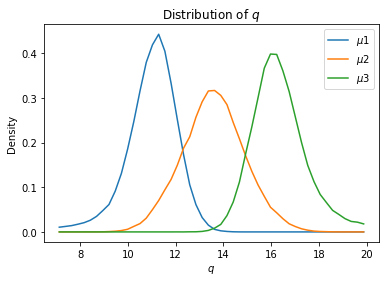

In [123]:
#mSGLD
new_q_traj=np.sort(q_traj)

histogram_m1,bins_m1 = np.histogram(new_q_traj[:,0],bins=50,range=[7,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(new_q_traj[:,1],bins=50,range=[7,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(new_q_traj[:,2],bins=50,range=[7,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

print('Mean 1:',np.mean(new_q_traj[:,0]), 'Standard Deviation:', np.std(new_q_traj[:,0]))
print('Mean 2:',np.mean(new_q_traj[:,1]),'Standard Deviation:', np.std(new_q_traj[:,1]))
print('Mean 3:',np.mean(new_q_traj[:,2]),'Standard Deviation:', np.std(new_q_traj[:,2]))